# Traitement Automatique de la Langue - TME2



## POS tagging, analyse des phrases



In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [75]:
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            #print "l : ",len(ligne)," ",ligne
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.split(" ")
            doc.append((mots[0],mots[1]))
    return listeDoc

# =============== chargement ============
filename = "data/wapiti/chtrain.txt" # a modifier
filenameT = "data/wapiti/chtest.txt" # a modifier

alldocs = load(filename)
alldocsT = load(filenameT)

print len(alldocs)," docs read"
print len(alldocsT)," docs (T) read"

823  docs read
77  docs (T) read


## Approche à base de dictionnaire

In [26]:
def naive_fit(docs):
    tags=dict()
    for doc in docs:
        for word in doc:
            tags[word[0]]=word[1]
    return tags

def naive_score(docs,tags):
    error=sum([1 if(tags.setdefault(w[0],0)!=w[1]) else 0 for doc in alldocsT for i,w in enumerate(doc)])
    nb_docs=len([True for doc in alldocsT for w in doc])
    return nb_docs-error,1-float(error)/nb_docs
 
tags=naive_fit(alldocs)
#print naive_score(alldocsT,tags)
           

463


##  Méthodes séquentielles

In [4]:
# allx: liste de séquences d'observations
# allq: liste de séquences d'états
# N: nb états
# K: nb observation

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-5
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # derniere transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,x[0]]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,x[t]]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[T-i] = psi[S[T-i+1],T-i+1]
    return S, logp #, delta, psi

### Mise en forme des données



In [5]:
# alldocs etant issu du chargement des données

buf = [[m for m,c in d ] for d in alldocs]
mots = []
[mots.extend(b) for b in buf]
mots = np.unique(np.array(mots))
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots))))
mots2ind["UUUUUUUU"] = len(mots)

buf2 = [[c for m,c in d ] for d in alldocs]
cles = []
[cles.extend(b) for b in buf2]
cles = np.unique(np.array(cles))
cles2ind = dict(zip(cles,range(len(cles))))

nCles = len(cles)

print nMots,nCles," in the dictionary"

# mise en forme des données
allx  = [[mots2ind[m] for m,c in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,c in d] for d in alldocsT]

allq  = [[cles2ind[c] for m,c in d] for d in alldocs]
allqT = [[cles2ind.setdefault(c,len(cles)) for m,c in d] for d in alldocsT]

4570 42  in the dictionary


### Application

In [6]:
Pi,A,B=learnHMM(allx,allq,nCles,nMots)
tags=list()
for doc in allxT: 
    tag,logp=viterbi(doc,Pi,A,B)
    tags.append(list(tag))

err=0
nb_w=0
hmm_conf=np.zeros((nCles,nCles))
for d in range(len(allqT)):
    for i in range(len(allqT[d])):
        if(allqT[d][i]!=tags[d][i]):
            hmm_conf[allqT[d][i]-1][tags[d][i]-1]+=1
            err+=1
        nb_w+=1
        
print 'Taux de classif avec HMM: '+str((1.-(float(err)/nb_w))*100)+'% de reussite'

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Taux de classif avec HMM: 81.0126582278% de reussite


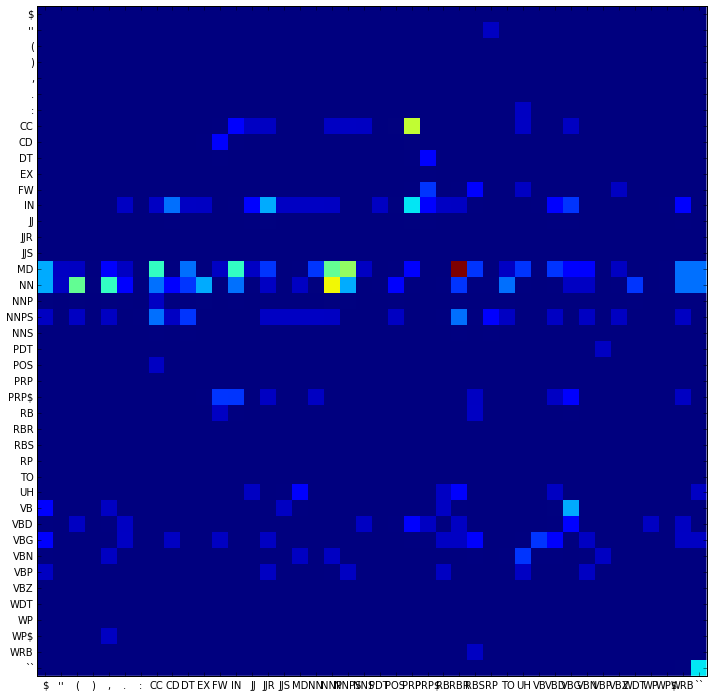

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(hmm_conf, interpolation='None')
localLabs = cles # liste des POS-TAG
plt.yticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.show()

### Matrice de confusion de l'approche a base de dictionnaire

In [56]:
err=0
nb_cles=len(np.unique([i[1] for d in alldocs for i in d]))
naive_conf=np.zeros((nb_cles,nb_cles))
for doc in alldocsT:
    for w in doc:
        t=tags.setdefault(w[0],0)
        if(t!=w[1]):
            err+=1
            if(t!=0):
                naive_conf[np.where(w[1]==cles)[0][0]][np.where(tags[w[0]]==cles)[0][0]]+=1
print err

463


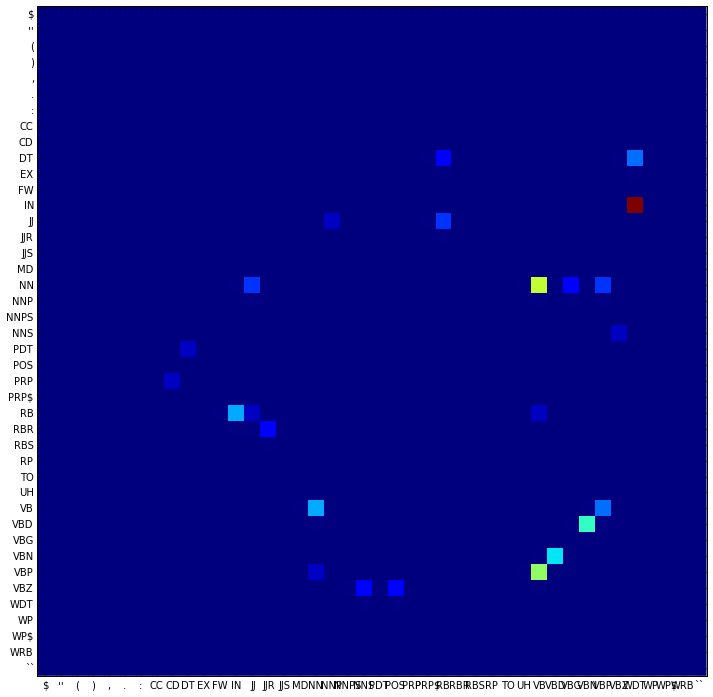

In [57]:
tags=naive_fit(alldocs)
plt.figure(figsize=(12,12))
plt.imshow(naive_conf, interpolation='None')
localLabs = cles # liste des POS-TAG
plt.yticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.xticks(range(len(localLabs)),localLabs) # affichage sur l'image
plt.show()

### Modfile pour wapiti

In [88]:
f_doc=[w[0] for d in alldocsT for w in d]
f=open("chtest_wapiti.txt","w")
for w in f_doc:
    f.write(w+'\n')
f.close()

### Script pour comparer avec wapiti

In [99]:
#open
wap=list()
with open("Wapiti/out.txt",'r') as f2:
    for line in f2:
        wap.append(line.split())
doc_mod=[w for d in alldocsT for w in d]
err=0
total=0
for i in range(len(doc_mod)):
    if(doc_mod[i][0]!=wap[i][0]):
        print 'Erreur!!'
    if(doc_mod[i][1]!=wap[i][1]):
        err+=1
    total+=1
print 'Taux de classif wapiti:'+str((1-float(err)/total)*100)+'%\n'

Taux de classif wapiti:95.9915611814%

